## Makemore MLP: activations & gradients

Building makemore Part 3: Activations & Gradients, BatchNorm
https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4


In [3]:
# Run using python 3.8.5 kernel 
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build vocab of chars and mapping to / from integers
chars = sorted(list(set(''.join(words)))) # get all distinct chars, sorted
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build dataset
block_size = 3 

def build_dataset(words): 

    X, Y = [], [] 

    for w in words: 
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]  
            X.append(context) 
            Y.append(ix) 
            context = context[1:] + [ix] 

    X = torch.tensor(X) 
    Y = torch.tensor(Y) 
    print(X.shape, Y.shape)
    return X, Y 

import random 
random.seed(42) 
random.shuffle(words) # mix up the words 
n1 = int(0.8*len(words)) # 80% of words 
n2 = int(0.9*len(words)) # 90% of words 

Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Changes we're making: 
* Starting weights of W2 very small and biases at 0 so that logits are smaller and therefore closer together 
* Fixed tanh layer saturation: Observed that h values are very much gathered around -1 and 1. Tanh is squashing values between -1 and 1 and it's taking in stuff that's too extreme so it has to put it at these extreme values. This is a problem because the gradient of tanh is almost 0 at extreme x vals so your backpropagation effect is very small. "Gradient vanishes". He explains that you have "dead neurons" when regardless of what example coming in, the gradient is extremely small -- the neuron won't learn and assist with anything

Because our network is small, it was very forgiving -- it learned after a lot of iteration. But once we're working with say 50 layers, these problems stack up. 

At first we set the scaling values manually to get our distributions looking good, but that's not ideal. We know that we want our outputs at each layer to look roughly like a unit Gaussian. 

Most common initialization is Kaiming normal. You can choose mode (fan in or fan out: this is whether you preserve unit variance in forward pass or backward) and what nonlinearity you're using. Fan in / fan out doesn't really matter. For tanh, gain is 5/3. 

In the last ~7 years there have been a lot of developments that make initialization. For him in simple cases, he'll set SDs to be square root of fan in (fan in = number of input neurons for the layer). 

In [ ]:
# MLP but more generalizable 
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                      generator=g) * 0.01 
# making weights and bias very small so that logits are closer together 
# i.e. start out thinking that everything is about equally likely 
# stops loss from looking like "hockey stick"
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01 
b2 = torch.randn(vocab_size,                    generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total num of parameters
for p in parameters: 
    p.requires_grad = True

11897


In [16]:
max_steps = 200000 
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # index randomly into train 
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors 
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function 

    # backward pass 
    for p in parameters: 
        p.grad = None 

    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break 
    

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


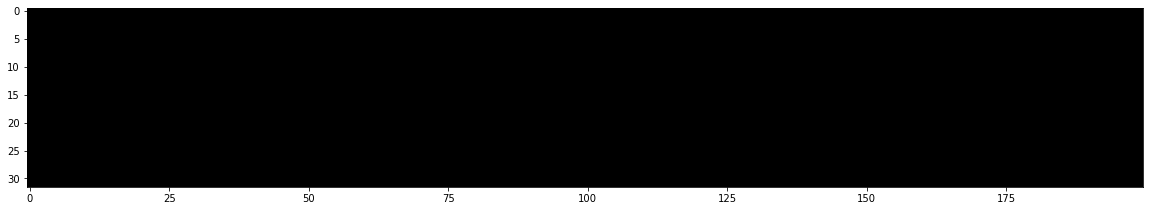

In [13]:
# to look at 'dead neurons' or just neurons that are very extreme for some examples
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([  6.,  17.,  20.,  30.,  49.,  61.,  72.,  89.,  87.,  99., 135.,
        121., 153., 134., 138., 140., 174., 163., 179., 184., 138., 196.,
        183., 226., 165., 212., 191., 175., 201., 211., 189., 186., 166.,
        178., 183., 156., 194., 155., 171., 140., 139., 122., 102.,  96.,
         81.,  72.,  41.,  39.,  23.,  18.]),
 array([-0.95476675, -0.91695145, -0.87913615, -0.84132085, -0.80350554,
        -0.76569024, -0.72787494, -0.69005964, -0.65224434, -0.61442904,
        -0.57661374, -0.53879843, -0.50098313, -0.46316783, -0.42535253,
        -0.38753723, -0.34972193, -0.31190663, -0.27409132, -0.23627602,
        -0.19846072, -0.16064542, -0.12283012, -0.08501482, -0.04719952,
        -0.00938421,  0.02843109,  0.06624639,  0.10406169,  0.14187699,
         0.17969229,  0.21750759,  0.2553229 ,  0.2931382 ,  0.3309535 ,
         0.3687688 ,  0.4065841 ,  0.4443994 ,  0.4822147 ,  0.52003   ,
         0.55784531,  0.59566061,  0.63347591,  0.67129121,  0.70910651,
 

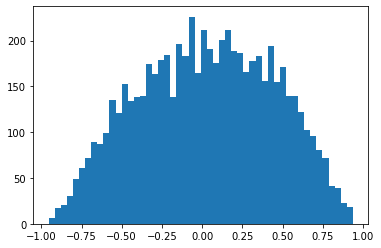

In [14]:
# to look at the distrn of vals in h 
plt.hist(h.view(-1).tolist(), 50)

In [ ]:
-torch.tensor(1/27.0).log() # we'd expect loss to start around this 

tensor(3.2958)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split): 
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) 
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


In [ ]:
g = torch.Generator().manual_seed(1234)

for _ in range(20): 
    out = []
    context = [0] * block_size 
    while True: 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() 
        context = context[1:] + [ix]
        out.append(ix) 
        if ix == 0: 
            break 

    print(''.join(itos[i] for i in out))

kend.
pardani.
fin.
averat.
ana.
zoyin.
treum.
mao.
orlis.
boumaya.
tren.
ryonathince.
dux.
maryan.
nio.
osido.
markonnie.
mana.
arnylon.
kaila.


### Another improvement: batch normalization 
Basically: if you want unit Gaussian weights, then normalize them 

It didn't improve much due to small size of our network, but it's common to add these batch normalization layers after every layer in a big complicated network. 

Interestingly, it also has a side effect as a regularizer. The scaling of hpreact now depends on the mean and std of the batch, meaning that h and the output depend not only on a neuron and one data point, but on all the data points in the batch, introducing a bit of entropy / 'jitter'. Makes it harder for the model to overfit and stabilizes training. People have tried to remove it and move to other regularization techniques but seems like there's some inertia on that bc it works decently well. 

Also note that biases before batch normalization won't do anything because we subtract out the means. The bnbias term takes care of all biasing 

In [28]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                      generator=g) * 0.01 
# making weights and bias very small so that logits are closer together 
# i.e. start out thinking that everything is about equally likely 
# stops loss from looking like "hockey stick"
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01 
b2 = torch.randn(vocab_size,                    generator=g) * 0 

# At initialization, we want it to be exactly unit Gaussian 
# so 1 * the necessary scaling + 0 = the necessary scaling
# but we also allow add it to params so network can adjust these vars
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total num of parameters
for p in parameters: 
    p.requires_grad = True

12297


In [ ]:
max_steps = 200000 
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) 
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)  
    hpreact = embcat @ W1 # + b1 
    # **this here is batch normalization 
    # for each neuron, we're normalizing across our 32 examples -- across the batch 
    # and this is differentiable 
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad(): 
        # gradually adjust towards the mean and std for when we calibrate at end
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) 

    # backward pass 
    for p in parameters: 
        p.grad = None 

    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break 
    

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [30]:
# Model now expects a batch in order to make a prediction 
# To get off that, we're going to "calibrate the batch norm"
# We moved this upward now into the training 
# with torch.no_grad(): 
#     # pass the training set thru 
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1 
#     # measure the mean / std over the entire training set 
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [31]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split): 
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    # these are adjusted to use our calibrated batch norm
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


* Discussed ResNet -- convolutional, but blocks made of layers and batch norm layers 
* Discussed pytorch's Linear object for initializing layers. You can say bias=False if you don't want bias just weights (as you would if you're following up w a batchnorm layer). Weights are initialized on a uniform distribution along sqrt(1/fan in), negative to positive 
* Looked at pytorch batchnorm layer as well. Good parameter to know: momentum. Basically determines how you update your estimate of the mean and SD (that will be used for calibration at the end). If batch size is small you generally want a small momentum; if big you can go bigger bc the vals should be more consistent batch to batch. track_running_stats determines if you want to do that whole process in the first place; if False you have to do the calibrating at the end yourself. 
* Group and layer normalization have become more common in deep learning and seems like he would prefer those. Batchnorm can create a lot of issues he says (the linking of one observation to others in a group is the root problem)


### Part 2: PyTorch-ifying our code 

In [20]:
# very similar to pytorch linear layer 
class Linear: 

    def __init__(self, fan_in, fan_out, bias=True): 
        # randn is unit Gaussian at first 
        # then we use Kanming by default 
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x): 
        self.out = x @ self.weight 
        if self.bias is not None: 
            self.out += self.bias 
        return self.out 
    
    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d: 

    def __init__(self, dim, eps=1e-5, momentum=0.1): 
        self.eps = eps  # for avoiding division by 0 
        self.momentum = momentum 
        self.training = True # bc we behave differently for train and inference
        # parameters (trained with backprop) 
        self.gamma = torch.ones(dim) # like gain above 
        self.beta = torch.zeros(dim) 
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim) 
        self.running_var = torch.ones(dim) 

    def __call__(self, x): 
        # calculate the forward pass 
        if self.training: 
            xmean = x.mean(0, keepdim=True) # batch mean 
            xvar = x.var(0, keepdim=True) # batch variance 
        else: 
            xmean = self.running_mean 
            xvar = self.running_var 
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # making it easier to maintain and plot 

        # update the buffers
        if self.training: 
            with torch.no_grad(): 
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar 
        return self.out 
    
    def parameters(self): 
        return [self.gamma, self.beta]

class Tanh: 
    def __call__(self, x): 
        self.out = torch.tanh(x) 
        return self.out 
    def parameters(self): 
        return []

In [8]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 100 # number of neurons in hidden layer 
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix starting random 
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad(): 
    # last layer: make less confident 
    layers[-1].weight *= 0.1 
    # all other layers: apply gain for tanh 
    for layer in layers[:-1]: 
        if isinstance(layer, Linear): 
            layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


46497


In [13]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []
ud = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors 
    for layer in layers: 
        x = layer(x) 
    loss = F.cross_entropy(x, Yb) # loss function 

    # backward pass 
    for layer in layers: 
        layer.out.retain_grad()  
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad(): 
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000: 
        break 

      0/ 200000: 3.2944


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

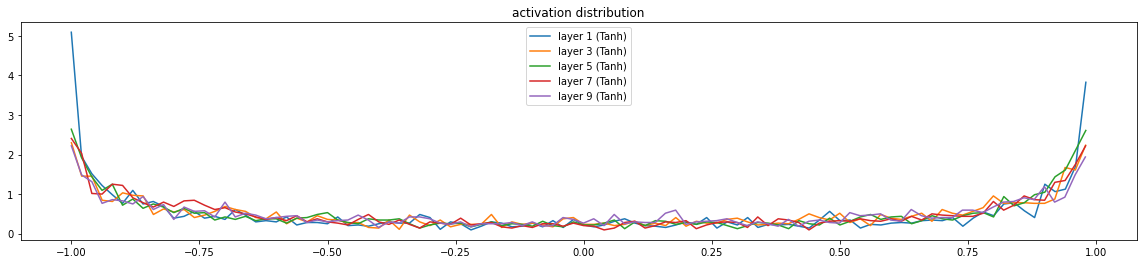

In [14]:
# visualize activation values at each layer 
# saturation % = % outputs that are 0.97 or more extreme 
# if we test gain of 1 we see too much gathering of vals in the middle; 
# test gain of 3 and see too much at edges. this is good balance for stacks of layers
# he seems surprisingly ok with 5% saturation -- this is where it stabilizes 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh): 
        t = layer.out 
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends); 
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

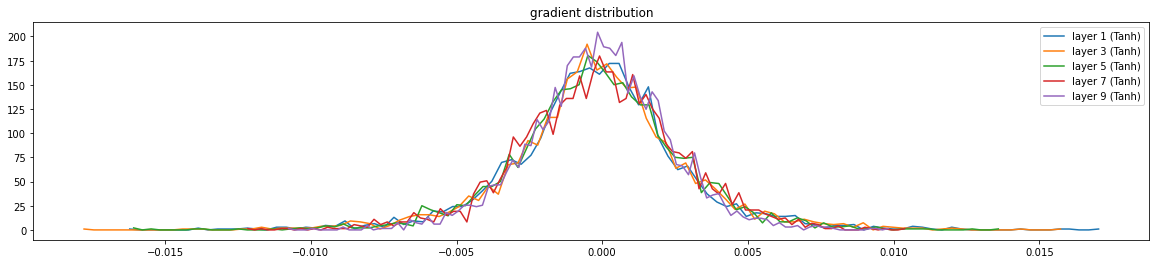

In [15]:
# we can do a similar thing with the gradients 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh): 
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends); 
plt.title('gradient distribution')

We also looked at what happened if we got rid of all our Tanh layers. The activation values become super spread out with more extreme values as layers go on. Which causes the gradients to get really small as layers go on. More well behaved with gain of 1. 

weight   (27, 10) | mean +0.000772 | std 9.714625e-03 | grad:data ratio 9.714511e-03
weight  (30, 100) | mean -0.000036 | std 8.734048e-03 | grad:data ratio 2.792836e-02
weight (100, 100) | mean +0.000085 | std 7.424626e-03 | grad:data ratio 4.417371e-02
weight (100, 100) | mean +0.000055 | std 6.242012e-03 | grad:data ratio 3.681917e-02
weight (100, 100) | mean +0.000007 | std 6.161661e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.221998e-03 | grad:data ratio 3.102273e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229573e-01


Text(0.5, 1.0, 'weights gradient distribution')

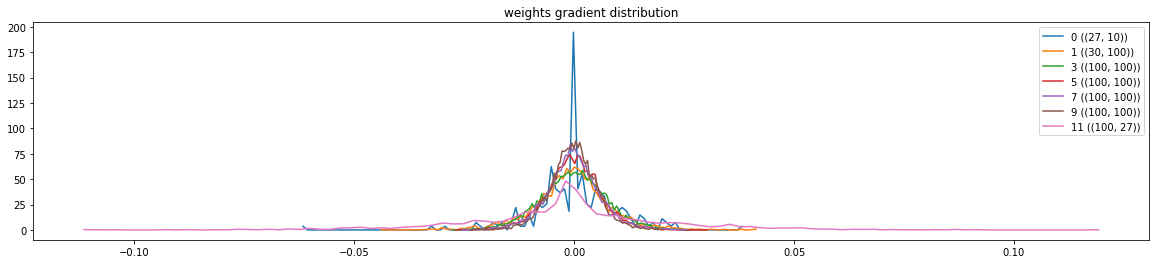

In [16]:
# finally, looking at our parameters 
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2: 
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends); 
plt.title('weights gradient distribution')

# grad:data ratio = scale of gradient relative to scale of data values 
# if gradient is too big compared to numbers in data, that's bad. 
# (although what really matters is update to data ratio)
# right now, last layer is training a lot faster (after first run)

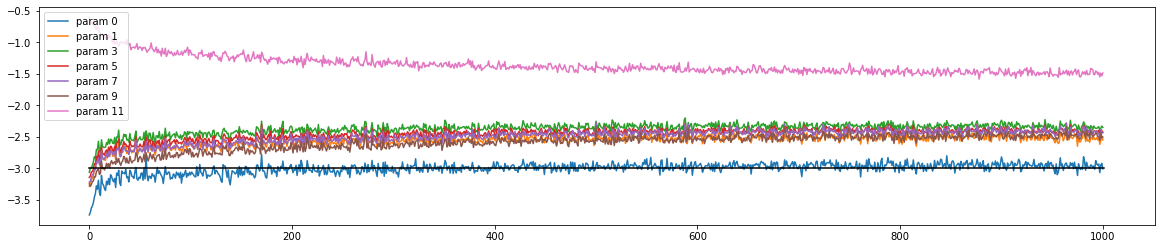

In [ ]:
# another plot he likes to look at when training NNs 
# looking at ratio of update amount to existing parameter value 
# he likes to make sure these vals are not too much above 1e-3
# if below, usually means params aren't training fast enough 
# can adjust learning rate based on this plot 
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): 
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be about 1e-3; indicate on plot
plt.legend(legends)

### Now trying batch norm layers instead of using gain to normalize our weights and output values 
Or it looks like we're still using gain but it doesn't matter as much (it's less "brittle" if we put in a gain that's kind of off)
We could also take out the fan in normalization when we initialize the weights and use gain = 1 

In [21]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 100 # number of neurons in hidden layer 
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix starting random 
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad(): 
    # last layer: make less confident 
    layers[-1].gamma *= 0.1 # gamma instead of weight!!
    # all other layers: apply gain for tanh 
    for layer in layers[:-1]: 
        if isinstance(layer, Linear): 
            layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


47551


In [22]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []
ud = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors 
    for layer in layers: 
        x = layer(x) 
    loss = F.cross_entropy(x, Yb) # loss function 

    # backward pass 
    for layer in layers: 
        layer.out.retain_grad()  
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad(): 
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000: 
        break 

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

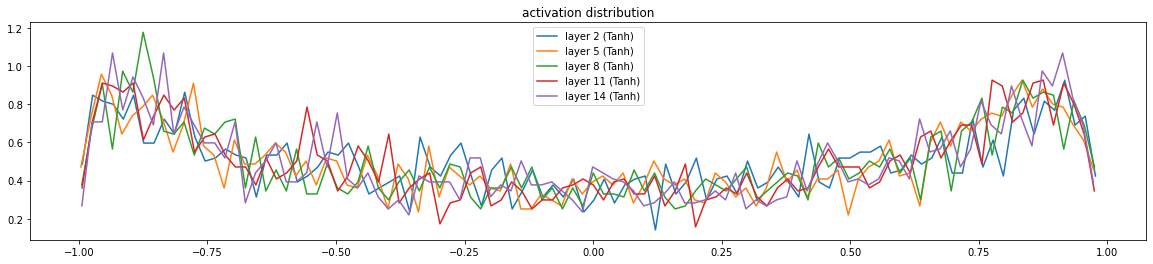

In [23]:
# visualize activation values at each layer 
# saturation % = % outputs that are 0.97 or more extreme 
# if we test gain of 1 we see too much gathering of vals in the middle; 
# test gain of 3 and see too much at edges. this is good balance for stacks of layers
# he seems surprisingly ok with 5% saturation -- this is where it stabilizes 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh): 
        t = layer.out 
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends); 
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

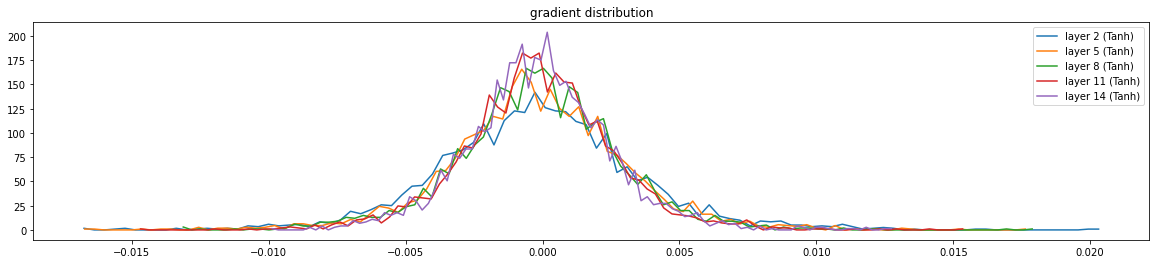

In [24]:
# we can do a similar thing with the gradients 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh): 
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends); 
plt.title('gradient distribution')

We also looked at what happened if we got rid of all our Tanh layers. The activation values become super spread out with more extreme values as layers go on. Which causes the gradients to get really small as layers go on. More well behaved with gain of 1. 

weight   (27, 10) | mean -0.000000 | std 1.019881e-02 | grad:data ratio 1.018842e-02
weight  (30, 100) | mean +0.000092 | std 8.238408e-03 | grad:data ratio 2.635832e-02
weight (100, 100) | mean +0.000031 | std 7.318091e-03 | grad:data ratio 4.377132e-02
weight (100, 100) | mean -0.000019 | std 6.662014e-03 | grad:data ratio 3.949890e-02
weight (100, 100) | mean -0.000019 | std 5.821508e-03 | grad:data ratio 3.468156e-02
weight (100, 100) | mean +0.000053 | std 5.445286e-03 | grad:data ratio 3.243361e-02
weight  (100, 27) | mean -0.000165 | std 1.046842e-02 | grad:data ratio 6.281251e-02


Text(0.5, 1.0, 'weights gradient distribution')

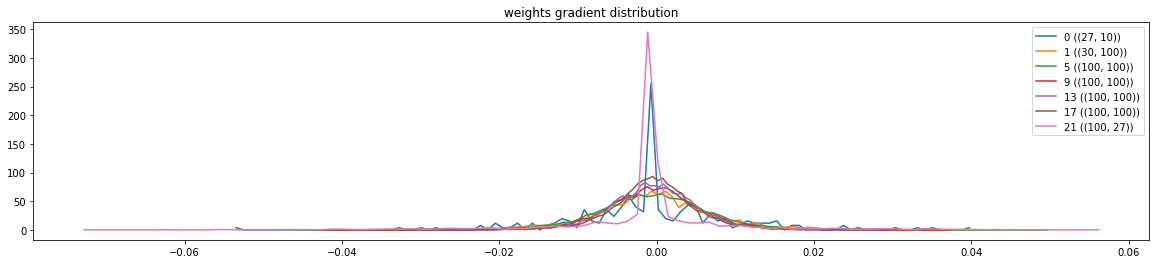

In [25]:
# finally, looking at our parameters 
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2: 
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends); 
plt.title('weights gradient distribution')

# grad:data ratio = scale of gradient relative to scale of data values 
# if gradient is too big compared to numbers in data, that's bad. 
# (although what really matters is update to data ratio)
# right now, last layer is training a lot faster (after first run)

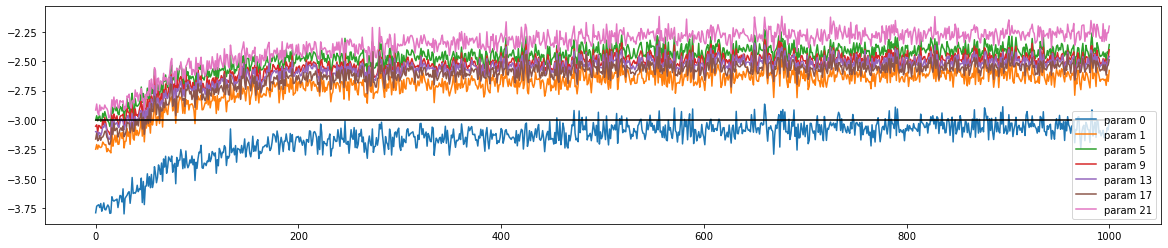

In [26]:
# another plot he likes to look at when training NNs 
# looking at ratio of update amount to existing parameter value 
# he likes to make sure these vals are not too much above 1e-3
# if below, usually means params aren't training fast enough 
# can adjust learning rate based on this plot 
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): 
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be about 1e-3; indicate on plot
plt.legend(legends)

Summary: 
* Explanation of batch normalization, which was big development for NNs stability 
* PyTorchified our code, making layers nice and stackable. Could actually use pytorch by preprending nn. to all our layers 
* Diagnostic tools to understand whether our NN is in a good state 
He tried training a more complex model with the batchnorm layers and these tools but actually got pretty similar loss as our simpler versions - he thinks we're bottlenecked at this point by context length of 3. 